# Model Fine-Tuning
In this case we will fine tune the CNN model form pretrained `MobileNet` on `ImageNet` dataset.
We may able to create a CNN from scratch, but utilizing transfer learning and fine-tunning will be more beneficial in terms of time and perfromance.

## Import Libraries

In [1]:
import mlflow
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2025-04-22 08:46:41.681152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745311601.701797  327177 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745311601.708081  327177 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745311601.724437  327177 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745311601.724455  327177 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745311601.724458  327177 computation_placer.cc:177] computation placer alr

## Check GPU Availability

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(f'{gpu.name}')
            print(f'Physical GPUs: {len(gpus)}')
            print(f'Logical GPUs: {len(logical_gpus)}')

        except RuntimeError as e:
            print(e)

/physical_device:GPU:0
Physical GPUs: 1
Logical GPUs: 1


I0000 00:00:1745311605.062708  327177 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14791 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


# Experiment Tracking
We will try to fine the best hyper-parameters for this model. So, we need an `MLFlow` or similar tools like `aimflow` to track all our experiments and log the models.

## Setup Experiment Tracking
We will try to find the best hyper-parameters for this model. So, we need an `MLFlow` or similar tools like `Weight and Biases` to track all our experiments and log the models.

Assume the MLFlow is already running by executing this command: `mlflow server --host 127.0.0.1 --port 5000`

In [3]:
EXPERIMENT_NAME = 'efficientnet-finetune-part2'
EXPERIMENT_BASE = 'http://127.0.0.1:5000'

# Setup tracking
mlflow.set_tracking_uri(uri=EXPERIMENT_BASE)
mlflow.enable_system_metrics_logging()

# Enable autologging for TensorFlow
mlflow.tensorflow.autolog()

# Set experiment name
mlflow.set_experiment(EXPERIMENT_NAME)

2025/04/22 08:46:45 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.18.0, but the installed version is 2.19.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.


<Experiment: artifact_location='mlflow-artifacts:/696277914735305910', creation_time=1745311230597, experiment_id='696277914735305910', last_update_time=1745311230597, lifecycle_stage='active', name='efficientnet-finetune-part2', tags={}>

# Hyper Parameters
Define hyper-parameters we will use

In [4]:
CLASS_NAMES = ['architecture', 'art and culture', 'food and drinks', 'travel and adventure']
CLASS_TO_INDEX = {name: idx for idx, name in enumerate(CLASS_NAMES)}

IMAGE_SIZE = IMAGE_HEIGHT, IMAGE_WIDTH = 320, 380
IMAGE_SHAPE = IMAGE_SIZE + (3,)

BASE_MODEL_NAMES = ['resnet_50', 'efficientnet', 'convnext', 'nasnet', 'mobilenet']

parameters = {
    'model': BASE_MODEL_NAMES[1],
    'width': IMAGE_WIDTH,
    'height': IMAGE_HEIGHT,
    'image_size': IMAGE_SIZE,
    'class_names': CLASS_NAMES,
    'learning_rate': 3e-6,
    'batch_size': 72,
    'dropout': 0.15,
    'dense': 128,
    'epochs': 24,
    'aug': 0.15,
    
    'frozen_layers_min': 30,
    'frozen_layers_initial': 0,
    'unfreeze_layers': 20,
}

# Load Datasets

In [5]:
TRAIN_DIR = '../datasets/train'
VAL_DIR = '../datasets/validation'

In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='categorical',
    class_names=parameters['class_names'],
    batch_size=parameters['batch_size'],
    image_size=parameters['image_size'],
    shuffle=True,
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    label_mode='categorical',
    class_names=parameters['class_names'],
    batch_size=parameters['batch_size'],
    image_size=parameters['image_size'],
    shuffle=True,
)

Found 34991 files belonging to 4 classes.
Found 115 files belonging to 4 classes.


## Preview Dataset
Let's see current original dataset

2025-04-22 08:46:48.958649: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


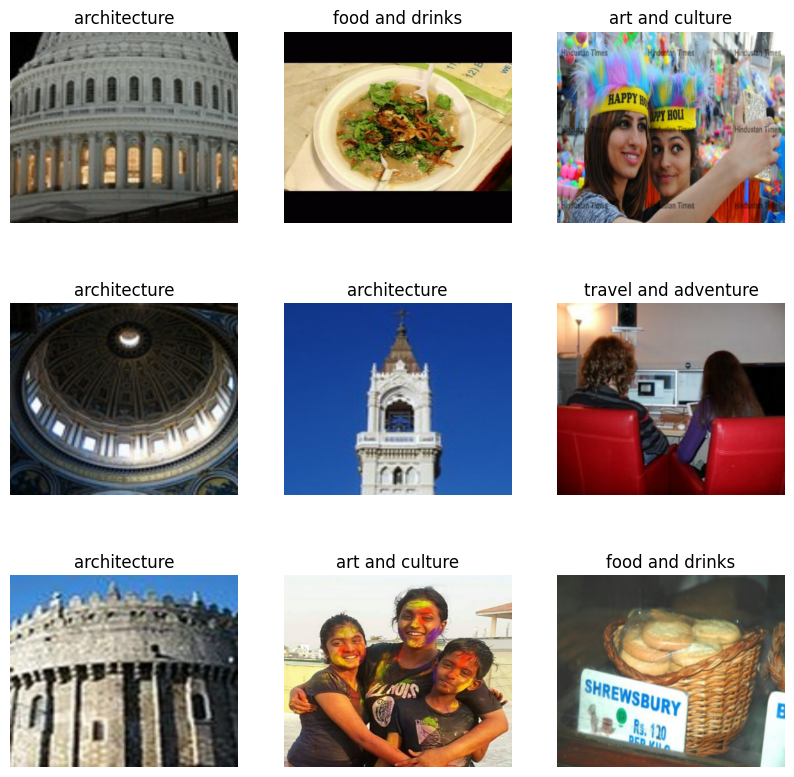

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(min(9, parameters['batch_size'])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i].numpy())])
    plt.axis("off")

## Prefect Dataset
To speed up the process of preprocessing the data and training the model, we can prefect the dataset so while the GPU is training the model, CPU will preparing the next dataset.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# Agumentation
Augmentation is a good technique to avoid overfitting on training dataset that can result hight accuracy on training data but lower on validation data.
The model will generalize the data and cancel the noise.

In [9]:
data_augmentation = tf.keras.Sequential([
    # Geometric Transformations
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),

    # # Color augmentations
    tf.keras.layers.RandomBrightness(factor=0.2),
    tf.keras.layers.RandomContrast(factor=0.2),
    tf.keras.layers.RandomHue(factor=0.1),
])

## Preview Augmentation

2025-04-22 08:46:53.857705: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


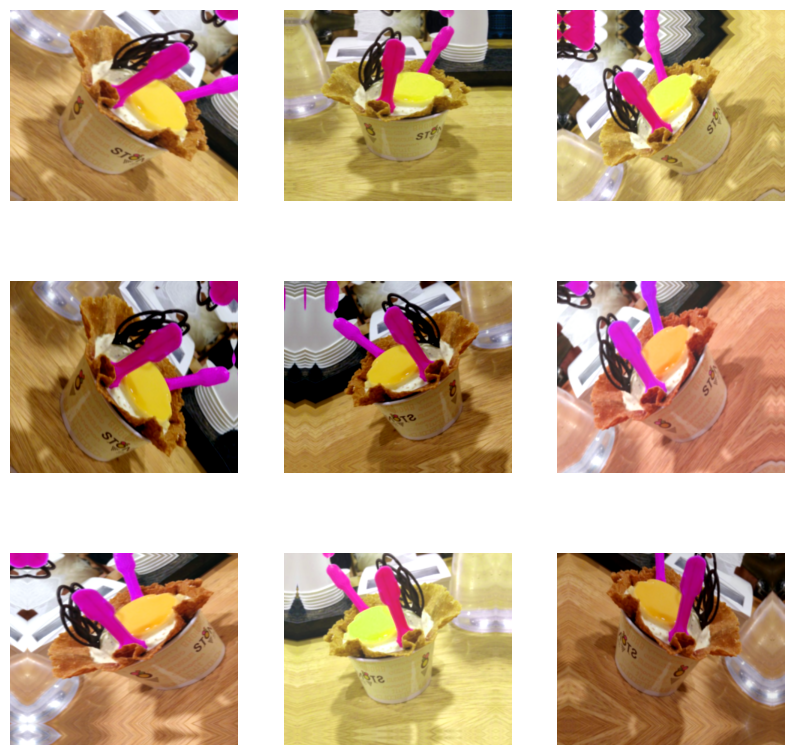

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Model

## Load Best Model

In [11]:
BEST_MODEL_PATH = 'mlflow-artifacts:/194910617187513883/0d50b1046741467cb188417656342196/artifacts/best' # val_loss, val_acc: (0.2277112454175949, 0.939130425453186)
BEST_MODEL_PATH = 'mlflow-artifacts:/674917377881405592/962463f7bd0749759040906e37298bd2/artifacts/best_acc' # val_loss, val_acc: (0.23772865533828735, 0.947826087474823)

model = mlflow.tensorflow.load_model(BEST_MODEL_PATH)
val_loss, val_acc = model.evaluate(validation_dataset)
print(f'val_loss, val_acc: {(val_loss, val_acc)}')

model.summary()

I0000 00:00:1745311623.416946  327279 cuda_dnn.cc:529] Loaded cuDNN version 90300


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 591ms/step - accuracy: 0.9374 - loss: 0.2550
val_loss, val_acc: (0.23772868514060974, 0.947826087474823)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 320, 380, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 320, 380, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 10, 12, 1280)        │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,878,953 (41.50 MB)

 Trainable params: 3,328,448 (12.70 MB)

 Non-trainable params: 893,607 (3.41 MB)

 Optimizer params: 6,656,898 (25.39 MB)

In [12]:
# 2. Inspect the base model
base_model = model.get_layer("efficientnetb0")
print(f"Before: base_model.trainable = {base_model.trainable}")

# 3. Unfreeze the base model
base_model.trainable = True

# Fine-tune only the top layers
for layer in base_model.layers[:parameters['frozen_layers_initial']]:
    layer.trainable = False

print(f"After: base_model.trainable = {base_model.trainable}")

# base_model.summary()
model.summary()

Before: base_model.trainable = True
After: base_model.trainable = True


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 320, 380, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 320, 380, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 10, 12, 1280)        │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,878,953 (41.50 MB)

 Trainable params: 3,328,448 (12.70 MB)

 Non-trainable params: 893,607 (3.41 MB)

 Optimizer params: 6,656,898 (25.39 MB)

In [13]:
class UnfreezeOnPlateau(tf.keras.callbacks.Callback):
    def __init__(self,
                 monitor='val_loss',
                 patience=3,
                 unfreeze_layers=1,
                 min_frozen_layers=0,
                 verbose=1):
        super().__init__()
        self.monitor = monitor
        self.patience = patience
        self.unfreeze_layers = unfreeze_layers
        self.min_frozen_layers = min_frozen_layers
        self.verbose = verbose

        self.wait = 0
        self.best = float('inf')
        self.need_recompile = False
        self.to_unfreeze = []

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return

        if current < self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1

        if self.wait > self.patience:
            base: tf.keras.Model = self.model.get_layer("efficientnetb0")
            frozen = [l for l in base.layers if not l.trainable]
            if len(frozen) <= self.min_frozen_layers:
                if self.verbose:
                    print(f"\nEpoch {epoch+1}: already at min frozen layers.")
                return

            # pick the top‑most N frozen layers to unfreeze next epoch
            self.to_unfreeze = frozen[-self.unfreeze_layers:]
            self.need_recompile = True
            if self.verbose:
                print(f"\nEpoch {epoch+1}: will unfreeze {len(self.to_unfreeze)} layer(s) next epoch.")
            self.wait = 0

    def on_epoch_begin(self, epoch, logs=None):
        if self.need_recompile:
            base: tf.keras.Model = self.model.get_layer("efficientnetb0")
            for layer in self.to_unfreeze:
                layer.trainable = True

            # re-compile *before* any batches
            self.model.compile(
                optimizer=self.model.optimizer,
                loss=self.model.loss,
                metrics=self.model.metrics,
                run_eagerly=False  # or True if you prefer
            )
            if self.verbose:
                print(f"\nEpoch {epoch+1}: unfreezing {len(self.to_unfreeze)} layer(s) and recompiling model.")
            self.need_recompile = False
            self.to_unfreeze = []


class LogFrozenLayers(tf.keras.callbacks.Callback):
    def __init__(self, base_model_name: str):
        super().__init__()
        self.base_model_name = base_model_name

    def on_epoch_end(self, epoch, logs=None):
        # Grab your base model by name
        base = self.model.get_layer(self.base_model_name)
        # Count how many layers have trainable=False
        frozen_count = sum(1 for l in base.layers if not l.trainable)
        # Log to MLflow with the epoch as the step
        mlflow.log_metric("frozen_layers", frozen_count, step=epoch)
        print(f"Epoch {epoch+1}: frozen_layers = {frozen_count}")

In [14]:
# 4. Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=parameters['learning_rate']),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

# Callbacks
checkpoint_path_acc = "checkpoints/efficientnetb0-fine_tune-high_acc.keras"
checkpoint_path_loss = "checkpoints/efficientnetb0-fine_tune-low_loss.keras"
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_acc, monitor='val_accuracy', save_best_only=True, mode='max'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_loss, monitor='val_loss', save_best_only=True, mode='min'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',     # Metric to monitor
        factor=0.5,             # Factor to reduce LR (new_lr = old_lr * factor)
        patience=2,             # Wait X epochs before reducing LR
        min_lr=1e-9,            # Do not go below this LR
        verbose=1,
    ),
]

In [15]:
# 5. Fine-tune the model
with mlflow.start_run() as run:
    # Log params
    mlflow.log_params(parameters)

    # Train
    history = model.fit(
        train_dataset,
        epochs=parameters['epochs'],
        validation_data=validation_dataset,
        batch_size=parameters['batch_size'],
        callbacks=callbacks,
    )
    
    # Load and Log: Best Accuracy
    mode_best_acc = tf.keras.models.load_model(checkpoint_path_acc)
    val_loss, val_acc = mode_best_acc.evaluate(validation_dataset)
    mlflow.tensorflow.log_model(mode_best_acc, "best_acc")
    mlflow.log_metric("best_accuracy", val_acc)

    # Load and Log: Best Loss
    mode_best_loss = tf.keras.models.load_model(checkpoint_path_loss)
    val_loss, val_acc = mode_best_acc.evaluate(validation_dataset)
    mlflow.tensorflow.log_model(mode_best_loss, "best_loss")
    mlflow.tensorflow.log_model(model, "last")
    mlflow.log_metric("best_loss", val_loss)

2025/04/22 08:47:05 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2025/04/22 08:47:05 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2025-04-22 08:47:06.218081: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:47:06.886073: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:47:08.443637: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:47:10.721171: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:47:14.622619: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:47:15.264094: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:47:15.726633: W tensorflow/core/lib/png/png

Epoch 1/24


E0000 00:00:1745311690.324601  327177 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-04-22 08:48:12.151788: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


  8/486 ━━━━━━━━━━━━━━━━━━━━ 1:31 192ms/step - accuracy: 0.8673 - loss: 0.3934

2025-04-22 08:48:14.462080: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 21/486 ━━━━━━━━━━━━━━━━━━━━ 1:29 192ms/step - accuracy: 0.8697 - loss: 0.3893

2025-04-22 08:48:16.963826: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 43/486 ━━━━━━━━━━━━━━━━━━━━ 1:25 192ms/step - accuracy: 0.8681 - loss: 0.3982

2025-04-22 08:48:21.216491: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 90/486 ━━━━━━━━━━━━━━━━━━━━ 1:15 191ms/step - accuracy: 0.8656 - loss: 0.4059

2025-04-22 08:48:30.131540: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:48:30.316231: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


100/486 ━━━━━━━━━━━━━━━━━━━━ 1:13 191ms/step - accuracy: 0.8654 - loss: 0.4065

2025-04-22 08:48:32.071976: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


113/486 ━━━━━━━━━━━━━━━━━━━━ 1:11 191ms/step - accuracy: 0.8652 - loss: 0.4070

2025-04-22 08:48:34.525430: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


121/486 ━━━━━━━━━━━━━━━━━━━━ 1:09 191ms/step - accuracy: 0.8651 - loss: 0.4071

2025-04-22 08:48:36.048828: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:48:36.049029: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


123/486 ━━━━━━━━━━━━━━━━━━━━ 1:09 191ms/step - accuracy: 0.8651 - loss: 0.4071

2025-04-22 08:48:36.420191: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


127/486 ━━━━━━━━━━━━━━━━━━━━ 1:08 191ms/step - accuracy: 0.8651 - loss: 0.4070

2025-04-22 08:48:37.199234: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


278/486 ━━━━━━━━━━━━━━━━━━━━ 39s 192ms/step - accuracy: 0.8654 - loss: 0.4050

2025-04-22 08:49:06.197348: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


309/486 ━━━━━━━━━━━━━━━━━━━━ 33s 192ms/step - accuracy: 0.8656 - loss: 0.4042

2025-04-22 08:49:12.192005: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


317/486 ━━━━━━━━━━━━━━━━━━━━ 32s 192ms/step - accuracy: 0.8657 - loss: 0.4040

2025-04-22 08:49:13.734656: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


342/486 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.8659 - loss: 0.4034

2025-04-22 08:49:18.452708: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


350/486 ━━━━━━━━━━━━━━━━━━━━ 26s 192ms/step - accuracy: 0.8659 - loss: 0.4033

2025-04-22 08:49:19.966374: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


355/486 ━━━━━━━━━━━━━━━━━━━━ 25s 191ms/step - accuracy: 0.8659 - loss: 0.4032

2025-04-22 08:49:20.893004: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


373/486 ━━━━━━━━━━━━━━━━━━━━ 21s 192ms/step - accuracy: 0.8661 - loss: 0.4027

2025-04-22 08:49:24.546016: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


376/486 ━━━━━━━━━━━━━━━━━━━━ 21s 192ms/step - accuracy: 0.8661 - loss: 0.4027

2025-04-22 08:49:24.973806: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:49:24.974539: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


412/486 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - accuracy: 0.8664 - loss: 0.4018

2025-04-22 08:49:31.789561: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


433/486 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.8665 - loss: 0.4013

2025-04-22 08:49:35.757294: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


479/486 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.8668 - loss: 0.4003

2025-04-22 08:49:44.472048: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:49:44.472535: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8669 - loss: 0.4002

2025/04/22 08:49:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot pickle 'module' object


486/486 ━━━━━━━━━━━━━━━━━━━━ 118s 202ms/step - accuracy: 0.8669 - loss: 0.4001 - val_accuracy: 0.9565 - val_loss: 0.2003 - learning_rate: 3.0000e-06
Epoch 2/24
  1/486 ━━━━━━━━━━━━━━━━━━━━ 2:22 295ms/step - accuracy: 0.8750 - loss: 0.3862

2025-04-22 08:49:51.395326: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


  3/486 ━━━━━━━━━━━━━━━━━━━━ 1:35 198ms/step - accuracy: 0.8920 - loss: 0.3525

2025-04-22 08:49:51.694907: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 22/486 ━━━━━━━━━━━━━━━━━━━━ 1:28 191ms/step - accuracy: 0.8768 - loss: 0.3621

2025-04-22 08:49:55.311916: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 48/486 ━━━━━━━━━━━━━━━━━━━━ 1:24 192ms/step - accuracy: 0.8746 - loss: 0.3648

2025-04-22 08:50:00.304978: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 96/486 ━━━━━━━━━━━━━━━━━━━━ 1:14 192ms/step - accuracy: 0.8744 - loss: 0.3667

2025-04-22 08:50:09.494130: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 99/486 ━━━━━━━━━━━━━━━━━━━━ 1:14 192ms/step - accuracy: 0.8744 - loss: 0.3667

2025-04-22 08:50:10.047625: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


102/486 ━━━━━━━━━━━━━━━━━━━━ 1:13 192ms/step - accuracy: 0.8745 - loss: 0.3668

2025-04-22 08:50:10.657982: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


112/486 ━━━━━━━━━━━━━━━━━━━━ 1:11 191ms/step - accuracy: 0.8744 - loss: 0.3670

2025-04-22 08:50:12.532708: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


124/486 ━━━━━━━━━━━━━━━━━━━━ 1:09 191ms/step - accuracy: 0.8744 - loss: 0.3669

2025-04-22 08:50:14.833901: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:50:14.834119: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB
2025-04-22 08:50:15.000867: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


130/486 ━━━━━━━━━━━━━━━━━━━━ 1:08 192ms/step - accuracy: 0.8745 - loss: 0.3667

2025-04-22 08:50:15.996358: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


290/486 ━━━━━━━━━━━━━━━━━━━━ 37s 191ms/step - accuracy: 0.8758 - loss: 0.3639

2025-04-22 08:50:46.619496: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


307/486 ━━━━━━━━━━━━━━━━━━━━ 34s 192ms/step - accuracy: 0.8759 - loss: 0.3636

2025-04-22 08:50:49.906136: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


314/486 ━━━━━━━━━━━━━━━━━━━━ 32s 192ms/step - accuracy: 0.8760 - loss: 0.3634

2025-04-22 08:50:51.235408: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


334/486 ━━━━━━━━━━━━━━━━━━━━ 29s 192ms/step - accuracy: 0.8761 - loss: 0.3630

2025-04-22 08:50:55.122864: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


352/486 ━━━━━━━━━━━━━━━━━━━━ 25s 192ms/step - accuracy: 0.8762 - loss: 0.3627

2025-04-22 08:50:58.546342: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


373/486 ━━━━━━━━━━━━━━━━━━━━ 21s 192ms/step - accuracy: 0.8763 - loss: 0.3623

2025-04-22 08:51:02.572526: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:51:02.572988: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


378/486 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - accuracy: 0.8764 - loss: 0.3623

2025-04-22 08:51:03.501488: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


383/486 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - accuracy: 0.8764 - loss: 0.3622

2025-04-22 08:51:04.451816: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


429/486 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.8766 - loss: 0.3615

2025-04-22 08:51:13.277511: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


430/486 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.8766 - loss: 0.3615

2025-04-22 08:51:13.520945: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


448/486 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - accuracy: 0.8766 - loss: 0.3613

2025-04-22 08:51:16.945652: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:51:16.945685: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8767 - loss: 0.3608

2025/04/22 08:51:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot pickle 'module' object


486/486 ━━━━━━━━━━━━━━━━━━━━ 95s 194ms/step - accuracy: 0.8768 - loss: 0.3608 - val_accuracy: 0.9565 - val_loss: 0.1809 - learning_rate: 3.0000e-06
Epoch 3/24
  2/486 ━━━━━━━━━━━━━━━━━━━━ 1:31 189ms/step - accuracy: 0.9028 - loss: 0.2934

2025-04-22 08:51:26.059172: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


  6/486 ━━━━━━━━━━━━━━━━━━━━ 1:33 196ms/step - accuracy: 0.8948 - loss: 0.3210

2025-04-22 08:51:26.772210: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 13/486 ━━━━━━━━━━━━━━━━━━━━ 1:32 195ms/step - accuracy: 0.8918 - loss: 0.3204

2025-04-22 08:51:28.177828: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 48/486 ━━━━━━━━━━━━━━━━━━━━ 1:24 192ms/step - accuracy: 0.8846 - loss: 0.3275

2025-04-22 08:51:34.853473: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 92/486 ━━━━━━━━━━━━━━━━━━━━ 1:15 191ms/step - accuracy: 0.8840 - loss: 0.3308

2025-04-22 08:51:43.207905: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 94/486 ━━━━━━━━━━━━━━━━━━━━ 1:14 191ms/step - accuracy: 0.8840 - loss: 0.3308

2025-04-22 08:51:43.572787: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 97/486 ━━━━━━━━━━━━━━━━━━━━ 1:14 191ms/step - accuracy: 0.8840 - loss: 0.3309

2025-04-22 08:51:44.164595: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


109/486 ━━━━━━━━━━━━━━━━━━━━ 1:11 191ms/step - accuracy: 0.8840 - loss: 0.3318

2025-04-22 08:51:46.444857: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


123/486 ━━━━━━━━━━━━━━━━━━━━ 1:09 190ms/step - accuracy: 0.8840 - loss: 0.3325

2025-04-22 08:51:49.039283: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:51:49.039316: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


126/486 ━━━━━━━━━━━━━━━━━━━━ 1:08 190ms/step - accuracy: 0.8840 - loss: 0.3326

2025-04-22 08:51:49.636579: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


128/486 ━━━━━━━━━━━━━━━━━━━━ 1:08 190ms/step - accuracy: 0.8840 - loss: 0.3327

2025-04-22 08:51:50.001665: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


278/486 ━━━━━━━━━━━━━━━━━━━━ 39s 191ms/step - accuracy: 0.8857 - loss: 0.3334

2025-04-22 08:52:18.574011: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


313/486 ━━━━━━━━━━━━━━━━━━━━ 33s 191ms/step - accuracy: 0.8860 - loss: 0.3330

2025-04-22 08:52:25.350022: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


320/486 ━━━━━━━━━━━━━━━━━━━━ 31s 191ms/step - accuracy: 0.8861 - loss: 0.3329

2025-04-22 08:52:26.680816: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


335/486 ━━━━━━━━━━━━━━━━━━━━ 28s 191ms/step - accuracy: 0.8862 - loss: 0.3327

2025-04-22 08:52:29.514478: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


354/486 ━━━━━━━━━━━━━━━━━━━━ 25s 191ms/step - accuracy: 0.8863 - loss: 0.3324

2025-04-22 08:52:33.138888: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:52:33.157270: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


370/486 ━━━━━━━━━━━━━━━━━━━━ 22s 191ms/step - accuracy: 0.8865 - loss: 0.3322

2025-04-22 08:52:36.224860: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:52:36.225304: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


377/486 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - accuracy: 0.8865 - loss: 0.3321

2025-04-22 08:52:37.557533: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


415/486 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - accuracy: 0.8867 - loss: 0.3317

2025-04-22 08:52:44.764507: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


435/486 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.8868 - loss: 0.3315

2025-04-22 08:52:48.557559: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:52:48.557938: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB
2025-04-22 08:52:48.575019: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


486/486 ━━━━━━━━━━━━━━━━━━━━ 93s 191ms/step - accuracy: 0.8870 - loss: 0.3310 - val_accuracy: 0.9391 - val_loss: 0.1827 - learning_rate: 3.0000e-06
Epoch 4/24
  2/486 ━━━━━━━━━━━━━━━━━━━━ 1:34 194ms/step - accuracy: 0.9271 - loss: 0.2827

2025-04-22 08:52:59.179572: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 16/486 ━━━━━━━━━━━━━━━━━━━━ 1:29 191ms/step - accuracy: 0.8935 - loss: 0.3107

2025-04-22 08:53:01.844480: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 18/486 ━━━━━━━━━━━━━━━━━━━━ 1:29 191ms/step - accuracy: 0.8928 - loss: 0.3106

2025-04-22 08:53:02.200416: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 41/486 ━━━━━━━━━━━━━━━━━━━━ 1:24 189ms/step - accuracy: 0.8908 - loss: 0.3100

2025-04-22 08:53:06.543335: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 91/486 ━━━━━━━━━━━━━━━━━━━━ 1:15 190ms/step - accuracy: 0.8901 - loss: 0.3139

2025-04-22 08:53:16.085899: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 95/486 ━━━━━━━━━━━━━━━━━━━━ 1:14 190ms/step - accuracy: 0.8901 - loss: 0.3139

2025-04-22 08:53:16.867682: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 98/486 ━━━━━━━━━━━━━━━━━━━━ 1:13 190ms/step - accuracy: 0.8902 - loss: 0.3139

2025-04-22 08:53:17.448291: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


112/486 ━━━━━━━━━━━━━━━━━━━━ 1:11 190ms/step - accuracy: 0.8903 - loss: 0.3139

2025-04-22 08:53:20.144709: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


115/486 ━━━━━━━━━━━━━━━━━━━━ 1:10 190ms/step - accuracy: 0.8903 - loss: 0.3140

2025-04-22 08:53:20.675612: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


120/486 ━━━━━━━━━━━━━━━━━━━━ 1:09 190ms/step - accuracy: 0.8903 - loss: 0.3139

2025-04-22 08:53:21.620237: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:53:21.620491: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


130/486 ━━━━━━━━━━━━━━━━━━━━ 1:07 191ms/step - accuracy: 0.8904 - loss: 0.3140

2025-04-22 08:53:23.556449: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


278/486 ━━━━━━━━━━━━━━━━━━━━ 39s 191ms/step - accuracy: 0.8909 - loss: 0.3154

2025-04-22 08:53:51.809370: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


310/486 ━━━━━━━━━━━━━━━━━━━━ 33s 191ms/step - accuracy: 0.8911 - loss: 0.3153

2025-04-22 08:53:57.874277: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


329/486 ━━━━━━━━━━━━━━━━━━━━ 29s 191ms/step - accuracy: 0.8912 - loss: 0.3152

2025-04-22 08:54:01.522779: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


335/486 ━━━━━━━━━━━━━━━━━━━━ 28s 191ms/step - accuracy: 0.8912 - loss: 0.3152

2025-04-22 08:54:02.645696: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


362/486 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - accuracy: 0.8914 - loss: 0.3150

2025-04-22 08:54:07.927160: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


370/486 ━━━━━━━━━━━━━━━━━━━━ 22s 191ms/step - accuracy: 0.8914 - loss: 0.3149

2025-04-22 08:54:09.514548: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


375/486 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - accuracy: 0.8915 - loss: 0.3149

2025-04-22 08:54:10.456521: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


387/486 ━━━━━━━━━━━━━━━━━━━━ 18s 191ms/step - accuracy: 0.8916 - loss: 0.3147

2025-04-22 08:54:12.771916: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:54:12.771950: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


421/486 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.8918 - loss: 0.3145

2025-04-22 08:54:19.233559: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


429/486 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.8919 - loss: 0.3144

2025-04-22 08:54:20.765748: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


440/486 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.8919 - loss: 0.3143

2025-04-22 08:54:22.893991: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:54:22.894199: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8921 - loss: 0.3140
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.500000053056283e-06.
486/486 ━━━━━━━━━━━━━━━━━━━━ 93s 192ms/step - accuracy: 0.8921 - loss: 0.3140 - val_accuracy: 0.9391 - val_loss: 0.1838 - learning_rate: 3.0000e-06
Epoch 5/24
 15/486 ━━━━━━━━━━━━━━━━━━━━ 1:28 188ms/step - accuracy: 0.8850 - loss: 0.2974

2025-04-22 08:54:34.815789: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 18/486 ━━━━━━━━━━━━━━━━━━━━ 1:27 188ms/step - accuracy: 0.8862 - loss: 0.2967

2025-04-22 08:54:35.371597: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:54:35.376844: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 60/486 ━━━━━━━━━━━━━━━━━━━━ 1:21 191ms/step - accuracy: 0.8908 - loss: 0.3065

2025-04-22 08:54:43.435195: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 90/486 ━━━━━━━━━━━━━━━━━━━━ 1:15 190ms/step - accuracy: 0.8927 - loss: 0.3074

2025-04-22 08:54:49.129081: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 95/486 ━━━━━━━━━━━━━━━━━━━━ 1:14 190ms/step - accuracy: 0.8929 - loss: 0.3073

2025-04-22 08:54:50.049973: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


106/486 ━━━━━━━━━━━━━━━━━━━━ 1:12 191ms/step - accuracy: 0.8935 - loss: 0.3069

2025-04-22 08:54:52.231949: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


115/486 ━━━━━━━━━━━━━━━━━━━━ 1:10 191ms/step - accuracy: 0.8939 - loss: 0.3065

2025-04-22 08:54:53.942185: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


122/486 ━━━━━━━━━━━━━━━━━━━━ 1:09 192ms/step - accuracy: 0.8942 - loss: 0.3060

2025-04-22 08:54:55.332097: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:54:55.332138: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


129/486 ━━━━━━━━━━━━━━━━━━━━ 1:08 192ms/step - accuracy: 0.8944 - loss: 0.3056

2025-04-22 08:54:56.701156: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


144/486 ━━━━━━━━━━━━━━━━━━━━ 1:05 191ms/step - accuracy: 0.8949 - loss: 0.3050

2025-04-22 08:54:59.549474: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


273/486 ━━━━━━━━━━━━━━━━━━━━ 40s 192ms/step - accuracy: 0.8958 - loss: 0.3021

2025-04-22 08:55:24.288675: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


308/486 ━━━━━━━━━━━━━━━━━━━━ 34s 192ms/step - accuracy: 0.8958 - loss: 0.3018

2025-04-22 08:55:30.960813: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


325/486 ━━━━━━━━━━━━━━━━━━━━ 30s 192ms/step - accuracy: 0.8959 - loss: 0.3016

2025-04-22 08:55:34.229716: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


333/486 ━━━━━━━━━━━━━━━━━━━━ 29s 192ms/step - accuracy: 0.8959 - loss: 0.3016

2025-04-22 08:55:35.779970: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


362/486 ━━━━━━━━━━━━━━━━━━━━ 23s 192ms/step - accuracy: 0.8960 - loss: 0.3013

2025-04-22 08:55:41.316994: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:55:41.329437: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


372/486 ━━━━━━━━━━━━━━━━━━━━ 21s 192ms/step - accuracy: 0.8960 - loss: 0.3013

2025-04-22 08:55:43.225345: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:55:43.225869: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB
2025-04-22 08:55:43.424040: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


425/486 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - accuracy: 0.8962 - loss: 0.3008

2025-04-22 08:55:53.494679: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:55:53.688618: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


442/486 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.8962 - loss: 0.3007

2025-04-22 08:55:56.792077: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:55:56.792292: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


486/486 ━━━━━━━━━━━━━━━━━━━━ 94s 192ms/step - accuracy: 0.8962 - loss: 0.3006 - val_accuracy: 0.9391 - val_loss: 0.1846 - learning_rate: 1.5000e-06
Epoch 6/24
  1/486 ━━━━━━━━━━━━━━━━━━━━ 2:38 328ms/step - accuracy: 0.9167 - loss: 0.2541

2025-04-22 08:56:05.847231: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:56:05.954764: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 19/486 ━━━━━━━━━━━━━━━━━━━━ 1:29 192ms/step - accuracy: 0.8760 - loss: 0.3224

2025-04-22 08:56:09.307163: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 45/486 ━━━━━━━━━━━━━━━━━━━━ 1:24 192ms/step - accuracy: 0.8802 - loss: 0.3138

2025-04-22 08:56:14.283736: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 89/486 ━━━━━━━━━━━━━━━━━━━━ 1:16 193ms/step - accuracy: 0.8846 - loss: 0.3087

2025-04-22 08:56:22.792233: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 97/486 ━━━━━━━━━━━━━━━━━━━━ 1:15 193ms/step - accuracy: 0.8853 - loss: 0.3077

2025-04-22 08:56:24.349026: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:56:24.361454: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


110/486 ━━━━━━━━━━━━━━━━━━━━ 1:12 193ms/step - accuracy: 0.8862 - loss: 0.3064

2025-04-22 08:56:26.830715: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


115/486 ━━━━━━━━━━━━━━━━━━━━ 1:11 193ms/step - accuracy: 0.8866 - loss: 0.3059

2025-04-22 08:56:27.775760: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


118/486 ━━━━━━━━━━━━━━━━━━━━ 1:10 193ms/step - accuracy: 0.8868 - loss: 0.3056

2025-04-22 08:56:28.379203: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:56:28.379242: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


146/486 ━━━━━━━━━━━━━━━━━━━━ 1:05 192ms/step - accuracy: 0.8883 - loss: 0.3036

2025-04-22 08:56:33.660020: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


285/486 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - accuracy: 0.8931 - loss: 0.2978

2025-04-22 08:57:00.382869: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


324/486 ━━━━━━━━━━━━━━━━━━━━ 31s 192ms/step - accuracy: 0.8938 - loss: 0.2970

2025-04-22 08:57:07.905092: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


330/486 ━━━━━━━━━━━━━━━━━━━━ 29s 192ms/step - accuracy: 0.8939 - loss: 0.2968

2025-04-22 08:57:09.029137: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


348/486 ━━━━━━━━━━━━━━━━━━━━ 26s 192ms/step - accuracy: 0.8942 - loss: 0.2965

2025-04-22 08:57:12.515584: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


354/486 ━━━━━━━━━━━━━━━━━━━━ 25s 192ms/step - accuracy: 0.8943 - loss: 0.2964

2025-04-22 08:57:13.666957: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


364/486 ━━━━━━━━━━━━━━━━━━━━ 23s 192ms/step - accuracy: 0.8944 - loss: 0.2963

2025-04-22 08:57:15.546864: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


372/486 ━━━━━━━━━━━━━━━━━━━━ 21s 192ms/step - accuracy: 0.8945 - loss: 0.2962

2025-04-22 08:57:17.129971: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:57:17.130004: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


383/486 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - accuracy: 0.8946 - loss: 0.2960

2025-04-22 08:57:19.134430: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


424/486 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - accuracy: 0.8951 - loss: 0.2954

2025-04-22 08:57:26.953146: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:57:26.956918: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


434/486 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.8952 - loss: 0.2953 

2025-04-22 08:57:28.901569: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-04-22 08:57:28.902093: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8956 - loss: 0.2949
Epoch 6: ReduceLROnPlateau reducing learning rate to 7.500000265281415e-07.
486/486 ━━━━━━━━━━━━━━━━━━━━ 94s 193ms/step - accuracy: 0.8956 - loss: 0.2949 - val_accuracy: 0.9304 - val_loss: 0.1847 - learning_rate: 1.5000e-06


2025-04-22 08:57:39.781934: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9571 - loss: 0.2032


2025/04/22 08:58:00 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 08:58:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9479 - loss: 0.2157


2025/04/22 08:58:13 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 08:58:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/22 08:58:24 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 08:58:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/22 08:58:34 INFO mlflow.system_metrics.system_metrics_monitor: Stoppin

🏃 View run painted-rook-739 at: http://127.0.0.1:5000/#/experiments/696277914735305910/runs/2d24cc4afb6b42ca8fe82afaca3813f0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/696277914735305910
